# Average Viewers for Twitch Streamers Report

### Goals
The goal of this project is to find a model that can reasonably the average viewers a streamer will receive in order to provide advice to those new or interested in streaming on Twitch over what variables are important towards increasing the number of average viewers. 
    
### Summary
This notebook will analyze a dataset* that contains various channel measures from the top 1000 most-watched Twitch streamers for the past year from June 10th, 2020 through June 10th, 2021. In particular, the average number of viewers a streamer has is significant as it reflects how consistent their audience numbers are and the strength of their viewer engagement. Additionally, it can affect the number and kinds of sponsorships they receive and the amount of money they earn. In the end, the model fitted included log transformed data on both the response variable and predictors chosen to predict the average viewers a streamer should expect to have. These predictors included watch time, stream time, and followers as they had moderately strong relationships with average viewers and were reasonable believed to affect the response variable the most.

### Results
The variables included in this data set were channel, watch time, stream time, peak viewers, average viewers, followers, followers gained, views gained, partnered, mature, and language. Of which, the latter three were categorical variables that would not be used in the model fitted as well as the channel name. From the initial narrowing of variables, a multiple linear regression model was fitted using the method of ordinary least-squares, but the regression results and histograms determined that log transformed data would be best to account for the extreme positively skewed data of the response variable, average viewers, and two of the three predictors, watch time and followers. As such, the resulting regression equation produced was as follows:

$Average \ Viewers = -10.1735 + 0.9151 \ log(Watch \ Time) - 0.0000006348 \ Stream \ Time + 0.0857 \ log(Followers)$

From the results of the overall F-test and the p-values of the predictors, it was concluded that the model and variables were statistically significant and that at least one of the beta coefficients is not equal to 0. The final model was used to make predictions of a subset of actual values from the dataset and determined to have an adjusted R-squared value of 59.9% for the specific training and testing data split. Since the model's objective was to be used toward advising newer streamers how many average viewers they show expect and which variables significantly affect the response variable, it was concluded that the final model was sufficient and would provide modest predictions. 


--

*Data was retrieved from [SullyGnome.com](https://SullyGnome.com) which gathers data using the Twitch API. 

Exploratory Data Analysis Dashboard: [Click here]()

GitHub Repository: [Click here]()

By: Jame Zou


## Data Loading & Pre-Processing

To start, we have to first import all the libraries we will be using and load in the data. 


In [106]:
# import libraries
import pandas as pd 
import numpy as np 
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_palette("deep")

# load data
df = pd.read_csv("twitch-streamers.csv")
df.head()

,Channel,Watch time,Stream time,Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
0,xQcOW,14643816405,223050,167224,65652,5832736,2795156,212704288,True,False,English
1,Gaules,9310487205,518580,387315,17953,2767576,1244103,158935550,True,True,Portuguese
2,auronplay,5865123615,59205,294791,99064,8816192,5610215,118312586,True,False,Spanish
3,ibai,5792555370,95520,1512479,60642,6275848,5011824,172723748,True,False,Spanish
4,NICKMERCS,5698598235,115020,371609,49544,5778143,2175740,76468327,True,False,English


The first five rows of the data provides a glimpse into what information is available and the kinds of analysis that can be conducted to support better understanding of the content. Although most of the column names accurately describe what is found in the column, further interpretation of some of them would help explain their relevance in the context of streaming. The `Watch time` and `Followers` columns are measures of a streamer's popularity since it denotes how many minutes people have spent watching their content and the number of people following them. Similarly, `Average viewers` is an indicator of the consistency in the number of viewers that a streamer gets on a daily basis which contributes to the streamer's success and popularity. And lastly, `Followers gained` and `Views gained` are signs of growth since they represent the change in following or views within the time frame. Therefore, it's important to keep in mind that these are many of these measures are totalled or obtained at the end of a year's worth for each streamer, with the exception of `Average viewers` and the categorical columns. 

As such, there are several numerical columns in the data, but to be sure let's check the data types. 

In [107]:
# check data types
df.dtypes

Channel             object
Watch time           int64
Stream time          int64
Peak viewers         int64
Average viewers      int64
Followers            int64
Followers gained     int64
Views gained         int64
Partnered             bool
Mature                bool
Language            object
dtype: object

So it seems that `Partnered` and `Mature` are both boolean columns, due to the true and false nature of their values, but the data type can be changed so that they can be included for later purposes.

In [108]:
# convert Partnered and Mature columns
df['Partnered'] = np.where(df['Partnered'].isin([True]), 1,0).astype(np.int64)
df['Mature'] = np.where(df['Mature'].isin([True]), 1,0).astype(np.int64)

# summarize DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Channel           1000 non-null   object
 1   Watch time        1000 non-null   int64 
 2   Stream time       1000 non-null   int64 
 3   Peak viewers      1000 non-null   int64 
 4   Average viewers   1000 non-null   int64 
 5   Followers         1000 non-null   int64 
 6   Followers gained  1000 non-null   int64 
 7   Views gained      1000 non-null   int64 
 8   Partnered         1000 non-null   int64 
 9   Mature            1000 non-null   int64 
 10  Language          1000 non-null   object
dtypes: int64(9), object(2)
memory usage: 86.1+ KB


The summary of the DataFrame confirms that the changes were success as the `Partnered` and `Mature` columns now have a numerical data type. With no missing values in the data either, the next step will be to see how strong the relationship is between variables by looking at the correlation coefficients displayed on a heat map.

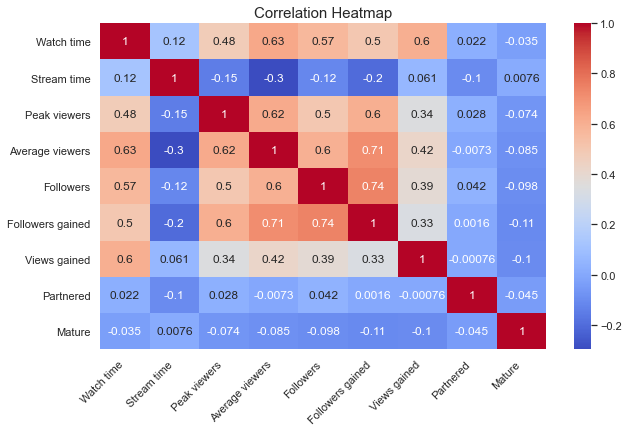

In [109]:
# drop non-numeric columns
df_numeric = df.drop(['Channel', 'Language'], axis=1) 
# retrieve correlation coefficients 
corrCoeff = np.corrcoef(df_numeric, rowvar=False)  
plt.figure(figsize=(10,6))
# create correlation heat map
sns.heatmap(corrCoeff, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap", fontsize=15)
plt.xticks(np.arange(9)+0.5, df_numeric.columns, rotation=45, ha='right')
plt.yticks(np.arange(9)+0.5, df_numeric.columns, rotation=0)
plt.show()

The heatmap directs our attention to a couple of noticeably higher correlation coefficients for `Average viewers` and `Followers` with the remaining variables. More specifically, `Average viewers` has moderately strong relationships, represented by coefficients ranging from 0.60 and up, with variables such as `Watch time`, `Peak viewers`, `Followers`, and `Followers gained`. As mentioned earlier, the average viewers a streamer receives is an important indicator of the streamer's success and popularity on Twitch as it demonstrates the number of people engaged with the streamer's content on a day-to-day basis. For that reason, follower counts are relatively less important since the average Twitch user could follow many channels, but only watch a couple, if any.

------------

## Initial Model

Now we can try to fit a model that can reasonably predict the average views a streamer will receive based on some of the variables found in our data. 

To do this, we'll use some of the numerical columns as the predictors with `Average viewers` as the response variable to produce a linear regression model using the ordinary least-squares (OLS) approach to minimize the error of the sum of squares. The columns we'll be most interested in using as the predictors are `Watch time`, `Stream time`, and `Followers` since the former two are related directly to the amount that the streamer streams for and the latter may provide a good idea of how many viewers there could possibly be. 

In [110]:
# create copy of data 
df_model = df[['Average viewers', 'Watch time', 'Stream time', 'Followers']].copy()
# select predictors
X = df_model.drop(['Average viewers'], axis=1)
# add constant/intercept
X = sm.add_constant(X)
# create response variable
y = df_model['Average viewers']
# apply statsmodels OLS function
model1 = sm.OLS(y, X)
# fit the model
results = model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Average viewers   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     459.4
Date:                Tue, 29 Jun 2021   Prob (F-statistic):          2.63e-187
Time:                        19:26:47   Log-Likelihood:                -10203.
No. Observations:                1000   AIC:                         2.041e+04
Df Residuals:                     996   BIC:                         2.043e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6362.0296    404.045     15.746      0.000    5569.153    7154.906
Watch time   5.958e-06   2.96e-07     20.156      0.000    5.38e-06    6.54e-06
Stream time    -0.0389      0.003    -15.444      0.000      -0.044      -0.034
Followers       0.0022      0.000     10.406      0.000       0.002       0.003
==============================================================================
Omnibus:                      791.540   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21826.965
Skew:                           3.411   Prob(JB):                         0.00
Kurtosis:                      24.847   Cond. No.                     2.08e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The summary of the OLS regression provides a deep look into various calculations concerning the model that is fitted and the first of importance are the values under the `P>|t|` column. This column provides that the shows that all of the variables used in the model are significant at the 5% level since their p-values are about 0. Any variables which didn't have a p-value less than 0.05 were dropped as well as variables which did not make sense to include such as `Peak viewers` whose would be greatly affected and skewed by the popularity of specific streamers and is to closely related to `Average viewers`. Meanwhile, the adjusted R-squared (adjusted multiple coefficient of determination) is 0.580 which suggests that 58% of the variability in average viewers can be explained by the model. Alternatively, it also indicates that 42% of the variability is unexplained. Therefore, it is also important to judge the usefulness of the model by seeing if the overall F-test has determined the model to be statistically significant as it compares the model to using an intercept-only model. At the 5% significance level, the results show that the probability of the F-statistic is far lower at 2.63e-187 which is about 0. In other words, this concludes that the model is statistically significant and  that at least one of the coefficients is not equal to 0. 

However, the high condition number indicates the possibility of multicollinearity. Multicollinearity occurs when predictors are highly correlated with each other which can affect the validity of the results from using the Method of Observed Least Squares. Although the correlation between all the predictors have already been viewed in the earlier heat map, a new measure, the variance inflation factor (VIF) of each predictor can be calculated to determine whether any of them are highly correlated. Variables with a VIF score greater than 10 generally indicate a multicollinearity issue.

In [111]:
# calculate VIF
vif_data = pd.DataFrame()
vif_data["variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                    for i in range(len(X.columns))]
vif_data

,variable,VIF
0,const,3.816295
1,Watch time,1.555237
2,Stream time,1.068401
3,Followers,1.554310


All the VIF values for all of the variables used in the model are all below 10, which denies the initial suspicions of multicollinearity. However, we should still check the scatterplot matrix to visualize how the variables plotted against each other as well as their distributions. Doing so would allow us to determine which variables may require tranformations for the fitted model. 





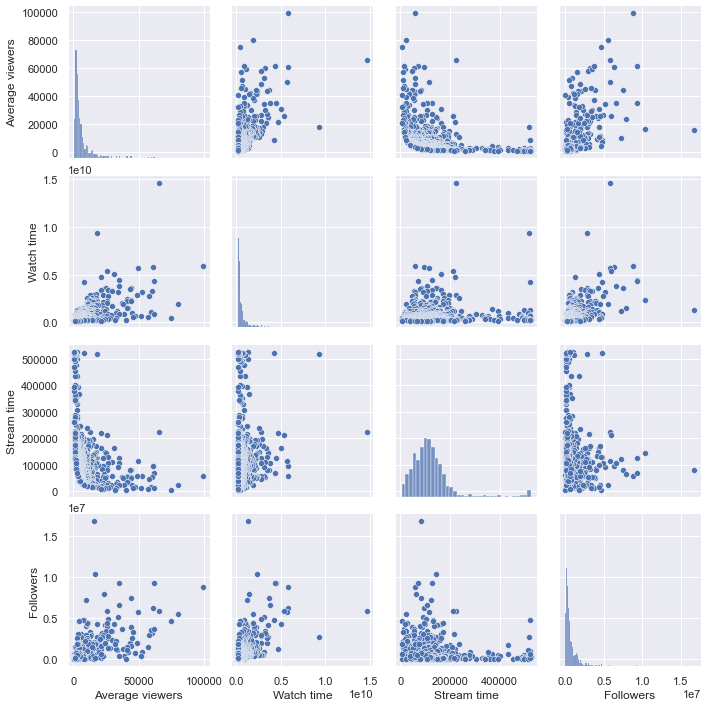

In [112]:
# generate pair plot
sns.pairplot(df_model)

From the pair plot, it is extremely clear that the variables we're working with are extremely right skewed especially in `Average viewers`, `Watch time` and `Followers`. The distribution shown in the histograms depict a positive skew since the majority of the data falls on the left side of the plot and trails off with a long tail to the right. Therefore, it would be best to use a log-log regression model. 

-------

## Log Transformed Predictor Variables 

Now we will fit a new regression model using log transformed data and apply the same OLS method.


In [125]:
# create new copy for data with logarithmic values
df_log = df[['Average viewers', 'Watch time', 'Stream time', 'Followers']].copy()
df_log[['log(Average viewers)', 'log(Watch time)', 'log(Followers)']] = df_log[['Average viewers', 'Watch time', 'Followers']].apply(np.log)
# select predictors
X_log = df_log[['log(Watch time)', 'Stream time', 'log(Followers)']]
# add constant/intercept
X_log = sm.add_constant(X_log)
# create response variable
y_log = df_log['log(Average viewers)']
# apply statsmodels OLS function
model2 = sm.OLS(y_log, X_log)
# fit the model
results = model2.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     log(Average viewers)   R-squared:                       0.867
Model:                              OLS   Adj. R-squared:                  0.867
Method:                   Least Squares   F-statistic:                     2165.
Date:                  Tue, 29 Jun 2021   Prob (F-statistic):               0.00
Time:                          20:07:23   Log-Likelihood:                -333.14
No. Observations:                  1000   AIC:                             674.3
Df Residuals:                       996   BIC:                             693.9
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -10.1735      0.297    -34.247      0.000     -10.756      -9.591
log(Watch time)     0.9151      0.019     48.531      0.000       0.878       0.952
Stream time     -6.348e-06   1.35e-07    -46.898      0.000   -6.61e-06   -6.08e-06
log(Followers)      0.0857      0.014      6.180      0.000       0.058       0.113
==============================================================================
Omnibus:                      519.728   Durbin-Watson:                   2.109
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3031.287
Skew:                           2.404   Prob(JB):                         0.00
Kurtosis:                      10.045   Cond. No.                     4.15e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.15e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The process repeats once more as we have to review a couple of the calculations from the regression summary. Similar to previous results, the overall F-test returns a value of 0 which denotes that at least one of the beta coefficients is not equal to 0. Meanwhile, the p-value for all of the variables are still lower than a 5% significance level which confirms their statistical significance. Lastly, the adjusted R-squared has increase to 0.867. This is a beneficial increase as it means that 86.7% of variation in average viewers can be explained by the new model. This suggests that the model is a better fit than the previous. As such, the new regression equation is as follows:

$Average \ Viewers = -10.1735 + 0.9151 \ log(Watch \ Time) - 0.0000006348 \ Stream \ Time + 0.0857 \ log(Followers)$

Now that this is complete, we can see how well our model predicts average viewers through the use of training and testing data that be split from the original dataset. And for the sake of being able to reproduce the same results, we will assign a value to the `random_state` parameter when retrieving the training and testing data. We also want to be especially cautious about either overfitting or underfitting the model.

In [177]:
# split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=26)
# force coefficients to be positive
lr = LinearRegression(positive=True)
# fit training variables
lr.fit(X_train, y_train)
# generate predictions
y_pred = lr.predict(X_test)

# create DataFrame of actual and predicted number of average viewers
df_model = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# calculate exponential of actual and predicted values
np.exp(df_model.head(10))

,Actual,Predicted
769,6050.0,2910.476560
824,13966.0,3107.310425
107,7916.0,8473.590260
921,1778.0,2228.372224
157,1815.0,6354.895220
333,5568.0,4175.459037
267,4719.0,4942.205124
480,1608.0,3445.616867
721,5693.0,2857.932944
719,2215.0,2625.368650


As shown above gives us the first ten rows of the actual values and the predictions calculated by the model. We can see that the predicted values are not especially close to the actual value, but most of them do not appear to be terribly far off. 

However, we can try to better understand the fit of the model towards the how accurately it predicts the average number of viewers, by calculating the adjusted R-squared value and root mean square of error. 

In [179]:
# variables to calculate adjusted r-squared
R2 = r2_score(y_test, y_pred)
n = 0.3*1000
k = 3
print('Adjusted R-squared: ', (1 - ((1-R2) * (n-1) / (n-k-1))))

# calculate RMSE using 
print('RMSE : ', np.sqrt(mean_squared_error(y_test,y_pred)))

Adjusted R-squared:  0.5993945684408428
RMSE :  0.569227681995724


For the specific selection of training and testing data, we obtain an adjusted R-squared value of 0.599 which states that 59.9% of the variation in average viewers can be explained by the model. Although the higher the adjusted R-squared value, the better the model fits, 59.9% isn't necessarily a bad value.  Meanwhile, the root mean square of error (RMSE), which is an absolute measure of fit, is about 0.569 and ideally we would want a lower value for the purpose of predictions. 

### Concluding Remarks
The interpretations of the measures used towards defining the strength of the model are very dependent on the overall goal we have for fitting the model, which is to provide insight and advice to newer streamers. Therefore, it's not crucial that the model needs to make predictions that are highly close to the actual values of the subset from the current dataset or for the various measures of fit to be the best possible. Due to the nature of the data that is being used, it is understandable for there to be outliers and other abnormalities because it is solely based on the top 1000 most-watched streamers and for the purpose of this project, we are looking for a model that can provide up-and-coming streamers ideas of how many average viewers they would be seeing. Ultimately, for the objective of the model fit, the values and measures calculated above are sufficient to support the model in making modest predictions of average viewers. 